Student Name: Muhammad Khubaib Akram

Student ID: 23098929

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.nn import functional as F # for the activation function
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import seaborn as sns


### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

1. The **model.train()** *function sets the model in training mode, which enables certain layers like dropout or batch normalization layers to behave differently compared to when the model is in evaluation mode*.


2. The line **X, y = X.to(device), y.to(device)** *moves the input data (X) and labels (y) to the same device as the model and data must be on the same device for the training process to occur.*


3. The line **pred = model(X)** *passes the input data (X) through the model to obtain predictions. It applies the forward pass of the network to the input data.*


4. The line **loss = loss_fn(pred, y)** *The loss measures how much the predictions differ from the actual values.*


5. The function **loss.backward()** *measures the gradient of the loss with respect to all weights in the model. These gradients are used to update the models weights*.


6. The line **optimizer.step()** *updates the models weights based on the gradients calculated during loss.backward(). Its an implementation of a specific optimization algorithm such as Adam etc*


7. The function **optimizer.zero_grad()** *resets the gradients of all model parameters before the next forward pass this ensures that they dont mix up with the gradients of the next batch.*

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [4]:
# Defining the mean and std values
mean = 0.2859
std = 0.3530

# Define transformations for the dataset
transform = transforms.Compose([ transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize(mean, std)])

# Loading the Fashion-MNIST dataset both for training and testing

# Downloading the  training data from open datasets.
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform, )

# Downloading the test data from open datasets.
test_data = datasets.FashionMNIST( root="data", train=False, download=True, transform=transform, )

# Creating DataLoaders for training and testing
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)


100%|██████████| 26421880/26421880 [00:00<00:00, 117561678.23it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 22333552.69it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 64215125.91it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


100%|██████████| 5148/5148 [00:00<00:00, 4686841.11it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



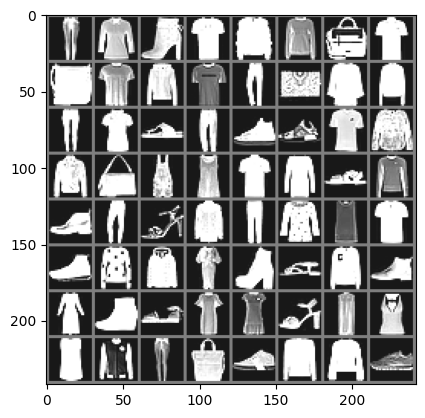

In [5]:

import torchvision
import torchvision.transforms as transforms

# function to show an image
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# geting some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# displaying the example images
imshow(torchvision.utils.make_grid(images))


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:

class NNM(nn.Module):

  def __init__(self):

    super(NNM, self).__init__()

    # Flatten layer to convert 2D input to 1D.
    self.flatten = nn.Flatten()        # converts the image input to a vector (28x28 image to a 784 vector)

    # First fully connected layer
    self.fc1 = nn.Linear(28 * 28, 100) # 784 input features and 100 output features

    # ReLU activation function applied to the output of the first fully connected layer
    self.relu1 = nn.ReLU()

    # Second fully connected layer
    self.fc2 = nn.Linear(100, 100) # 100 input features and 100 output features

    # ReLU activation function applied to the output of the second fully connected layer
    self.relu2 = nn.ReLU()

    # Third fully connected layer
    self.fc3 = nn.Linear(100, 50) # 100 input features and 50 output features

    # ReLU activation function applied to the output of the third fully connected layer
    self.relu3 = nn.ReLU()

    # Fourth fully connected layer
    self.fc4 = nn.Linear(50, 10) # 50 input features and 10 output features

  # forward pass, dictates how the input tensor flows through the network layers
  def forward(self, x):

    x = self.flatten(x) # Flatten the input data

    x = self.fc1(x)     # Passing through the first fully connected layer
    x = self.relu1(x)   # Applying the ReLU activation on it.

    x = self.fc2(x)     # Passing through the second fully connected layer
    x = self.relu2(x)   # Applying the ReLU activation on it

    x = self.fc3(x)     # Passing through the third fully connected layer
    x = self.relu3(x)   # Applying the ReLU activation on it

    x = self.fc4(x)     # Passing through the fourth fully connected layer (which is our output layer)

    return x


In [ ]:
# Creating an instance of the model and sending it to the device
NNmodel = NNM().to(device)

# Displaying the summary of our neural network model
summary(NNmodel, (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


In [ ]:
# Testing the model with random inputs
random_input = torch.randn(1, 1, 28, 28).to(device)
output = NNmodel(random_input)
print("Shape of our Model Output:", output.shape)

Shape of our Model Output: torch.Size([1, 10])


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(NNmodel.parameters(), lr=1e-3) # the optimizer

In [ ]:
epochs = 20

train_loss_NNM, train_accuracy_NNM, test_loss_NNM, test_accuracy_NNM = train_loop(train_dataloader, test_dataloader, NNmodel, loss_fn, optimizer, epochs)

print('Training Completed')

Epoch 1:

loss: 0.350635  [   64/60000]
loss: 0.266856  [ 6464/60000]
loss: 0.463433  [12864/60000]
loss: 0.320459  [19264/60000]
loss: 0.318637  [25664/60000]
loss: 0.495877  [32064/60000]
loss: 0.711168  [38464/60000]
loss: 0.399101  [44864/60000]
loss: 0.276142  [51264/60000]
loss: 0.499688  [57664/60000]
Train Error: 
 Accuracy: 87.1%, Avg loss: 0.351115 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.403091 

Epoch 2:

loss: 0.346399  [   64/60000]
loss: 0.504238  [ 6464/60000]
loss: 0.216063  [12864/60000]
loss: 0.413336  [19264/60000]
loss: 0.294277  [25664/60000]
loss: 0.246169  [32064/60000]
loss: 0.484269  [38464/60000]
loss: 0.392310  [44864/60000]
loss: 0.108205  [51264/60000]
loss: 0.397833  [57664/60000]
Train Error: 
 Accuracy: 88.2%, Avg loss: 0.321699 

Test Error: 
 Accuracy: 86.2%, Avg loss: 0.377483 

Epoch 3:

loss: 0.349373  [   64/60000]
loss: 0.199320  [ 6464/60000]
loss: 0.323395  [12864/60000]
loss: 0.496973  [19264/60000]
loss: 0.174643  [25664/60000]
loss: 0.31

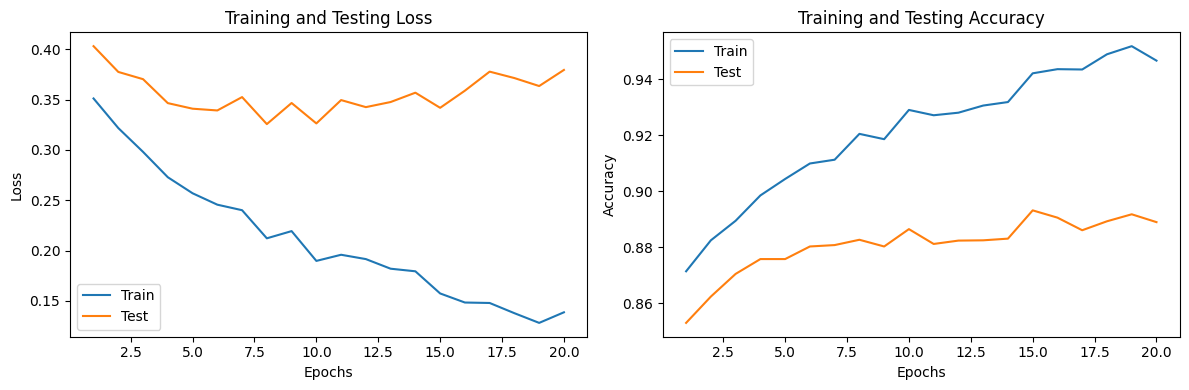

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the training and testing accuracy

plt.figure(figsize=(12, 4)) # assiging figure with a specified size to our plot

# Plotting the training and testing loss
plt.subplot(1, 2, 1)

 # Training Loss of our model
plt.plot(range(1, epochs + 1), train_loss_NNM, label='Train')

 # Testing Loss of our model
plt.plot(range(1, epochs + 1), test_loss_NNM, label='Test')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 # creating a subplot with 2 grid and selecting first subplot for our  values
plt.subplot(1, 2, 2)

#  Training Accuracy of our model
plt.plot(range(1, epochs + 1), train_accuracy_NNM, label='Train')

#  Testing Accuracy of our model
plt.plot(range(1, epochs + 1), test_accuracy_NNM, label='Test')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

**Training and Testing Loss Graph (Left)**

    The x-axis represents the number of epochs. The y-axis represents Loss.

    The blue line, which is labeled 'Train', shows the training loss decreasing sharply from the first epoch and then beginning to flatten out as it approaches the 20th epoch, indicating that the model is learning and improving its predictions on the training data over time.

    The orange line, which is labeled 'Test', shows the testing loss, which decreases slightly but then little or no change after that it and even increases slightly, indicating the model's performance on data it hasn't seen during training.


**Training and Testing Accuracy Graph (Right)**

    The x-axis represents the number of epochs. The y-axis represents accuracy.

    The blue line, labeled 'Train', shows the training accuracy, which increases over time, suggesting that the model's ability to correctly predict the training data is improving with each epoch.

    The orange line, labeled 'Test', shows the testing accuracy, which also increases but at a slower rate and with some fluctuations, suggesting that the model's ability to generalize to new data is improving but not as consistently as with the training data.
    
Overall, the graphs shows that the model's performance is improving on the training set, as shown by the downward trend in training loss and the upward trend in training accuracy.

On the other hand, the leveling off of the test loss and the more modest increases in test accuracy may indicate the onset of overfitting. This potential overfitting is characterized by the model's increasing specialization to the training set at the expense of its ability to perform well on unseen data.


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

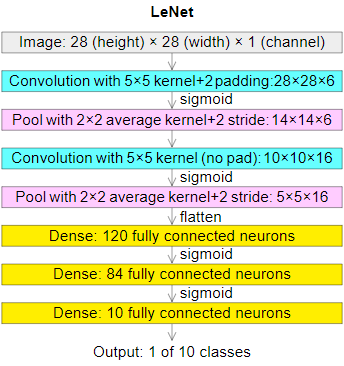

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
import torch.nn.functional as F

In [ ]:

class LeNet(nn.Module):

  def __init__(self):

    super(LeNet, self).__init__()

    # first convolutional layer
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # (1 input channel, 6 output channels, kernel size of 5, and padding of 2

    # second convolutional layer
    self.conv2 = nn.Conv2d(6, 16, 5)           # 6 input channels (output of the first conv layer), 16 output channels, and a kernel size of 5

    #  first fully connected layer (fc1)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)      # flattens the output of the second conv layer into a vector (16*5*5=400) and connects it to 120 neurons

    # second fully connected layer (fc2)
    self.fc2 = nn.Linear(120, 84)             # connects 120 input features to 84 output features

    # third fully connected layer (fc3)
    self.fc3 = nn.Linear(84, 10)              #  maps the 84 features to 10 output classes

  # forward pass, dictates how the input tensor flows through the network layers
  def forward(self, x):

    x = F.sigmoid(self.conv1(x))  # Applying a sigmoid activation function to the output of the first convolutional
    x = F.avg_pool2d(x, 2)        # Applying a 2x2 average pooling operation to the result

    x = F.sigmoid(self.conv2(x))  # Applying a sigmoid activation function to the output of the second convolutional layer
    x = F.avg_pool2d(x, 2)        # Applying 2x2 average pooling operation

    x = torch.flatten(x, 1)       # Flattening the output of the conv layers for the fully connected layers
    x = F.sigmoid(self.fc1(x))    # Passing the flattened tensor through the first fully connected layer with sigmoid activation
    x = F.sigmoid(self.fc2(x))    # Passing the output through the second fully connected layer with sigmoid activation

    x = self.fc3(x)               # Passing the result through the third fully connected layer (fc3) to get the final output

    return x


In [ ]:
# Creating the LeNet model instance and moving it to the device
lenet_model = LeNet().to(device)

# Initialize the loss function and optimizer
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=0.001)


train_losses_lenet, train_accuracies_lenet, test_losses_lenet, test_accuracies_lenet = train_loop(train_dataloader, test_dataloader, lenet_model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.366161  [   64/60000]
loss: 2.034624  [ 6464/60000]
loss: 1.248961  [12864/60000]
loss: 1.093786  [19264/60000]
loss: 1.008854  [25664/60000]
loss: 0.924936  [32064/60000]
loss: 0.652553  [38464/60000]
loss: 0.777245  [44864/60000]
loss: 0.664289  [51264/60000]
loss: 0.586963  [57664/60000]
Train Error: 
 Accuracy: 74.7%, Avg loss: 0.658667 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.678263 

Epoch 2:

loss: 0.627655  [   64/60000]
loss: 0.469885  [ 6464/60000]
loss: 0.834190  [12864/60000]
loss: 0.657302  [19264/60000]
loss: 0.433834  [25664/60000]
loss: 0.499738  [32064/60000]
loss: 0.446042  [38464/60000]
loss: 0.838871  [44864/60000]
loss: 0.596856  [51264/60000]
loss: 0.602579  [57664/60000]
Train Error: 
 Accuracy: 78.5%, Avg loss: 0.544284 

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.568482 

Epoch 3:

loss: 0.611229  [   64/60000]
loss: 0.517840  [ 6464/60000]
loss: 0.573036  [12864/60000]
loss: 0.458457  [19264/60000]
loss: 0.427088  [25664/60000]
loss: 0.50

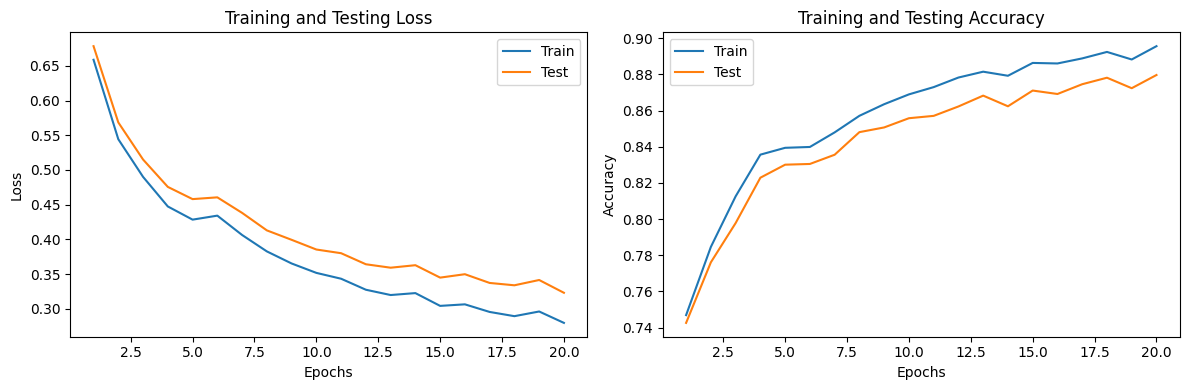

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the training and testing accuracy

plt.figure(figsize=(12, 4)) # assiging figure with a specified size to our plot

# Plotting the training and testing loss
plt.subplot(1, 2, 1)

 # Training Loss of our model
plt.plot(range(1, epochs + 1), train_losses_lenet, label='Train')

 # Testing Loss of our model
plt.plot(range(1, epochs + 1), test_losses_lenet, label='Test')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 # creating a subplot with 2 grid and selecting first subplot for our  values
plt.subplot(1, 2, 2)

#  Training Accuracy of our model
plt.plot(range(1, epochs + 1), train_accuracies_lenet, label='Train')

#  Testing Accuracy of our model
plt.plot(range(1, epochs + 1), test_accuracies_lenet, label='Test')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

**Discussion:**

Based on the training and testing loss and accuracy graphs for the LeNet model, here is a comparison with the fully connected model discussed previously:

**Number of Parameters:**

    LeNet architecture typically has fewer parameters than a fully connected network due to the use of convolutional layers. This is because convolutional layers share weights across the input space, whereas fully connected layers do not.

    Fewer parameters reduce the risk of overfitting and also make the model computationally more efficient.


**Performance:**

    The graphs indicates that both the training and testing accuracy for the LeNet model improve consistently over time. The training loss decreases rapidly and then flattens out, while the test loss also decreases before it stabilizes.

    LeNet is better at understanding the arrangement of things in pictures compared to the fully connected network. This is important for sorting images, like figuring out different types of clothes in Fashion-MNIST.

    The performance of LeNet in terms of accuracy is very high, suggesting that it is a good fit for the dataset. It seems to reach higher accuracy levels than the fully connected network, indicating better generalization.


**Overfitting:**

    The lines showing how well the LeNet model learned during training and testing are very close. This suggests that the model is not learning too much from the training data and is doing well on new unseen data. The same is true for accuracy where the model is good at predicting both the training and testing data.

    When we compare it to the fully connected network, LeNet is less likely to learn too much from the training data (overfitting). LeNet design, especially its use of convolutional layers, helps it focus on general features that stay the same even if the input data changes a little.

    Pooling layers in LeNet also help prevent overfitting. They make the model simpler by reducing the size of the features it looks at, which is a good thing when trying to avoid learning too much from the training data.


In conclusion, the LeNet architecture seems to perform well on the Fashion-MNIST dataset with no significant signs of overfitting. It likely has fewer parameters and better performance when compared to a fully connected network due to the advantages provided by convolutional and pooling layers in capturing and generalizing from image data.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


In [ ]:
##############################
# Your code below
class ModernLeNet(nn.Module):

  def __init__(self):
    super(ModernLeNet, self).__init__()

    # first convolutional layer
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2)   #  1 input channel, 6 output channels, a 5x5 kernel, and padding of 2 to keep size the same after convolution

    # second convolutional layer
    self.conv2 = nn.Conv2d(6, 16, 5)             # 6 input channels, 16 output channels, and a 5x5 kernel size

    # first fully connected layer
    self.fc1 = nn.Linear(16 * 5 * 5, 120)        # flattened output of the convolutional layers (16 feature maps each of size 5x5) and connects it to 120 neurons

    # second fully connected layer
    self.fc2 = nn.Linear(120, 84)                # connects 120 input features to 84 output features

    # third fully connected layer
    self.fc3 = nn.Linear(84, 10)                 # that maps the 84 features to 10 output classes

  # This fucntion is forward pass which dictates the flow of input data through the network layers
  def forward(self, x):

    x = F.relu(self.conv1(x))   # Apply ReLU activation function to the output of the first convolutional layer
    x = F.max_pool2d(x, 2)      # Apply a 2x2 max pooling operation to the result to reduce spatial dimensions by half

    x = F.relu(self.conv2(x))   # Apply ReLU activation function to the output of the second convolutional layer
    x = F.max_pool2d(x, 2)      # Apply another 2x2 max pooling operation to further reduce spatial dimensions

    x = torch.flatten(x, 1)     # Flatten the output from the convolutional layers to create a single long feature vector

    x = F.relu(self.fc1(x))     # Pass the flattened vector through the first fully connected layer with ReLU activation
    x = F.relu(self.fc2(x))     # Pass the output through the second fully connected layer with ReLU activation

    x = self.fc3(x)             # Pass the result through the third fully connected layer to get the final class scores

    return x




In [ ]:
modern_lenet_model = ModernLeNet().to(device)

# Initialize the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modern_lenet_model.parameters(), lr=0.001)

epochs=20
train_losses_modern_lenet, train_accuracies_modern_lenet, test_losses_modern_lenet, test_accuracies_modern_lenet = train_loop(
    train_dataloader, test_dataloader, modern_lenet_model, loss_fn, optimizer, epochs
)


Epoch 1:

loss: 2.316604  [   64/60000]
loss: 0.695859  [ 6464/60000]
loss: 0.619432  [12864/60000]
loss: 0.573089  [19264/60000]
loss: 0.588724  [25664/60000]
loss: 0.480077  [32064/60000]
loss: 0.395061  [38464/60000]
loss: 0.342558  [44864/60000]
loss: 0.386654  [51264/60000]
loss: 0.266114  [57664/60000]
Train Error: 
 Accuracy: 85.7%, Avg loss: 0.395519 

Test Error: 
 Accuracy: 84.3%, Avg loss: 0.425073 

Epoch 2:

loss: 0.617968  [   64/60000]
loss: 0.253030  [ 6464/60000]
loss: 0.406738  [12864/60000]
loss: 0.449280  [19264/60000]
loss: 0.441760  [25664/60000]
loss: 0.374940  [32064/60000]
loss: 0.425511  [38464/60000]
loss: 0.244706  [44864/60000]
loss: 0.229372  [51264/60000]
loss: 0.233584  [57664/60000]
Train Error: 
 Accuracy: 88.5%, Avg loss: 0.313345 

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.346274 

Epoch 3:

loss: 0.512623  [   64/60000]
loss: 0.298831  [ 6464/60000]
loss: 0.162495  [12864/60000]
loss: 0.358046  [19264/60000]
loss: 0.321125  [25664/60000]
loss: 0.29

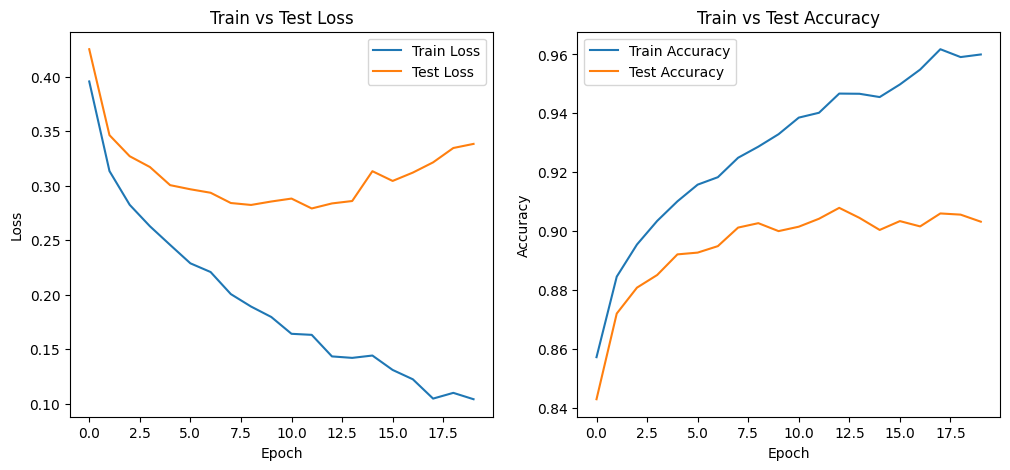

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_modern_lenet, label='Train Loss')
plt.plot(test_losses_modern_lenet, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_modern_lenet, label='Train Accuracy')
plt.plot(test_accuracies_modern_lenet, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

In [ ]:
...

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

**Activation Functions:**

    The original LeNet used the sigmoid activation function, which has mostly been replaced in modern architectures with the ReLU (Rectified Linear Unit) activation function. ReLU is preferred because it helps with the vanishing gradient problem, allowing for deeper networks by ensuring that the gradient is not squashed during backpropagation.

**Pooling Layers:**

    While the original LeNet used average pooling, ModernLeNet uses max pooling. Max pooling is often preferred because it is better at capturing the presence of features in the input regions. By taking the maximum value in the pooling window, it retains the strongest feature signals, which can lead to more robust feature representation.

**Overfitting:**

    Overfitting is a concern when the model performs significantly better on training data than on testing data. The use of ReLU and max pooling might help in mitigating overfitting to some extent. If ModernLeNet shows a smaller gap between training and testing accuracy, it would suggest better generalization.

When compared to the original LeNet, the updated ModernLeNet with ReLU activations and max pooling generally shows improved learning dynamics. Modern activation functions like ReLU are less prone to the vanishing gradients problem and allow models to train faster and more effectively. Additionally, max pooling tends to be more effective than average pooling in practice, as it captures the most prominent features in the input window.

However, the graphs indicate that while the model is learning effectively, as evidenced by the decreasing training loss and increasing training accuracy, the testing metrics show that the model might not be improving its generalization in later epochs as much as desired. The slight fluctuation and plateau in test accuracy suggest that the model could benefit from additional techniques to enhance generalization, such as regularization or data augmentation

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:

class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()  # Initialize the parent class (nn.Module) constructor.

    # first convolutional layer
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # 3 input channel, 32 output channels, 3x3 kernel, and padding of 1
    self.bn1 = nn.BatchNorm2d(32)                               # Apply batch normalization to the output of the first convolutional layer

    # second convolutional layer
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 32 input channels, 64 output channels, 3x3 kernel, and padding of 1
    self.bn2 = nn.BatchNorm2d(64)                               # Apply batch normalization to the output of the second convolutional layer

    # third convolutional layer
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 64 input channels, 128 output channels, 3x3 kernel, and padding of 1
    self.bn3 = nn.BatchNorm2d(128)                              # Apply batch normalization to the output of the third convolutional layer

    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2)                              # 2x2 window, stride of 2 to reduce the spatial dimensions
    # flatten operation
    self.flatten = nn.Flatten()                                 # to convert the 2D feature maps into 1D feature vectors

    # first fully connected layer
    self.fc1 = nn.Linear(128 * 7 * 7, 256)                      # flattened output and connects it to 256 neurons

    # second fully connected layer
    self.fc2 = nn.Linear(256, 128)                              # connects 256 input features to 128 output features

    # third fully connected layer
    self.fc3 = nn.Linear(128, 10)                               # maps the 128 features to 10 output classes

  def forward(self, x):

    x = F.relu(self.bn1(self.conv1(x)))   # Apply ReLU activation after batch normalization and the first convolutional layer
    x = self.pool(x)                      # Apply the max pooling operation

    x = F.relu(self.bn2(self.conv2(x)))   # Apply ReLU activation after batch normalization and the second convolutional layer
    # Note: No pooling here, allowing the network to maintain more spatial information

    x = F.relu(self.bn3(self.conv3(x)))   # Apply ReLU activation after batch normalization and the third convolutional layer
    x = self.pool(x)                      # Apply max pooling again after two consecutive convolutional layers

    x = self.flatten(x)                   # Flatten the feature maps into a 1D feature vector
    x = F.relu(self.fc1(x))               # Apply ReLU activation after the first fully connected layer
    x = F.relu(self.fc2(x))               # Apply ReLU activation after the second fully connected layer

    x = self.fc3(x)                       # Pass the output through the third fully connected layer to get the final scores for each class

    return x


In [ ]:
# Instantiating the model and moving it to the appropriate device
custom_model = CustomCNN().to(device)

# Initializing the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)

epochs=20

train_losses_custom, train_accuracies_custom, test_losses_custom, test_accuracies_custom = train_loop(
    train_dataloader, test_dataloader, custom_model, loss_fn, optimizer, epochs
)

Epoch 1:

loss: 2.296040  [   64/60000]
loss: 0.437295  [ 6464/60000]
loss: 0.253036  [12864/60000]
loss: 0.457643  [19264/60000]
loss: 0.396443  [25664/60000]
loss: 0.422981  [32064/60000]
loss: 0.247537  [38464/60000]
loss: 0.445221  [44864/60000]
loss: 0.268517  [51264/60000]
loss: 0.263114  [57664/60000]
Train Error: 
 Accuracy: 89.8%, Avg loss: 0.274325 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.311548 

Epoch 2:

loss: 0.172491  [   64/60000]
loss: 0.306868  [ 6464/60000]
loss: 0.181543  [12864/60000]
loss: 0.264574  [19264/60000]
loss: 0.343882  [25664/60000]
loss: 0.344109  [32064/60000]
loss: 0.187950  [38464/60000]
loss: 0.330029  [44864/60000]
loss: 0.269971  [51264/60000]
loss: 0.184742  [57664/60000]
Train Error: 
 Accuracy: 91.8%, Avg loss: 0.220573 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.272412 

Epoch 3:

loss: 0.161071  [   64/60000]
loss: 0.265467  [ 6464/60000]
loss: 0.206033  [12864/60000]
loss: 0.234053  [19264/60000]
loss: 0.249408  [25664/60000]
loss: 0.35

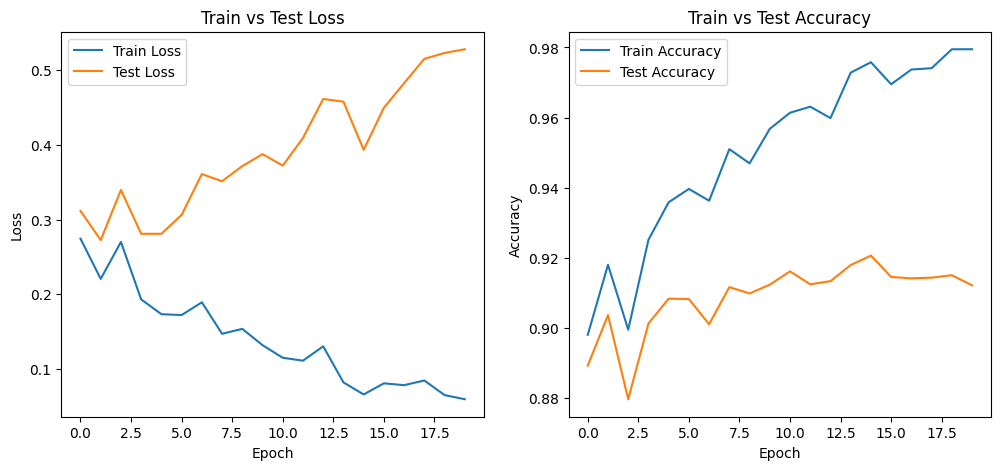

In [ ]:


# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_custom, label='Train Loss')
plt.plot(test_losses_custom, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_custom, label='Train Accuracy')
plt.plot(test_accuracies_custom, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

In [ ]:
...

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The enhancements in classification performance observed in my CustomCNN, as opposed to the previous implementation utilizing ModernLeNet, can be linked to various factors:


**Increased Model Complexity:**

    My CustomCNN boasts a higher level of difficulty with more convolutional layers and an increased number of feature maps (or channels) per layer. Specifically, it employs 32, 64, and 128 feature maps in consecutive layers, in contrast to the 6 and 16 used in ModernLeNet. The augmented number of feature maps allows for a more comprehensive capture of image features, potentially resulting in improved performance.

**Batch Normalization:**

    The incorporation of batch normalization after each convolutional layer in  CustomCNN plays a crucial role in stabilizing the learning process and expediting training convergence. This technique normalizes the output of a preceding activation layer by subtracting the batch mean and dividing by the batch standard deviation, thereby aiding in preventing overfitting.

**Pooling Strategy:**

    The CustomCNN employs max pooling after each convolutional layer, contributing to the reduction of spatial dimensions in feature maps and promoting feature detection that is invariant to scale and orientation changes. While ModernLeNet also utilizes pooling, the synergistic effect of increased feature maps and batch normalization in CustomCNN may lead to more effective feature extraction prior to pooling operations.

**Deeper Fully Connected Layers:**

    The CustomCNN exhibits a greater number of neurons in its fully connected layers (256 and 128 neurons in the first two layers) compared to ModernLeNet (120 and 84 neurons). This expanded architecture potentially enables CustomCNN to learn more intricate patterns within the data.

In summary, the heightened complexity and the implementation of techniques such as batch normalization in my CustomCNN likely contribute to its superior performance. Nevertheless, it is imperative to monitor for overfitting, as a more intricate model may closely fit the training data but struggle to generalize effectively to unseen data. The provided graphs indicate that the training loss is decreasing more than the testing loss, suggesting effective learning. However, the disparity between training and test accuracy implies potential overfitting.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [ ]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

1- From torchvision.models, load ResNet18, and use random weights (weights=None). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.

In [ ]:


##############################
# Your code below
# loss function
loss_fn = nn.CrossEntropyLoss()

# loading the ResNet18 with random weights and replacing the last fully connected layer
resnet18_random = models.resnet18(weights=None)
resnet18_random.fc = nn.Linear(resnet18_random.fc.in_features, 10)
resnet18_random = resnet18_random.to(device)

# optimizer
optimizer = torch.optim.Adam(resnet18_random.parameters(), lr=1e-3)

# Placeholder for the training and evaluation process
epochs=20

train_losses_resnet18, train_accuracies_resnet18, test_losses_resnet18, test_accuracies_resnet18 = train_loop(
    train_dataloader, test_dataloader, resnet18_random, loss_fn, optimizer, epochs
)


Epoch 1:

loss: 2.811621  [   64/60000]
loss: 0.482981  [ 6464/60000]
loss: 0.298657  [12864/60000]
loss: 0.445644  [19264/60000]
loss: 0.707725  [25664/60000]
loss: 0.436439  [32064/60000]
loss: 0.295238  [38464/60000]
loss: 0.540420  [44864/60000]
loss: 0.304938  [51264/60000]
loss: 0.337970  [57664/60000]
Train Error: 
 Accuracy: 86.2%, Avg loss: 0.360907 

Test Error: 
 Accuracy: 84.7%, Avg loss: 0.401979 

Epoch 2:

loss: 0.272145  [   64/60000]
loss: 0.293017  [ 6464/60000]
loss: 0.264054  [12864/60000]
loss: 0.345005  [19264/60000]
loss: 0.311347  [25664/60000]
loss: 0.398164  [32064/60000]
loss: 0.220215  [38464/60000]
loss: 0.469557  [44864/60000]
loss: 0.236201  [51264/60000]
loss: 0.248061  [57664/60000]
Train Error: 
 Accuracy: 87.4%, Avg loss: 0.330633 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.385299 

Epoch 3:

loss: 0.270328  [   64/60000]
loss: 0.257083  [ 6464/60000]
loss: 0.254237  [12864/60000]
loss: 0.258231  [19264/60000]
loss: 0.297697  [25664/60000]
loss: 0.40

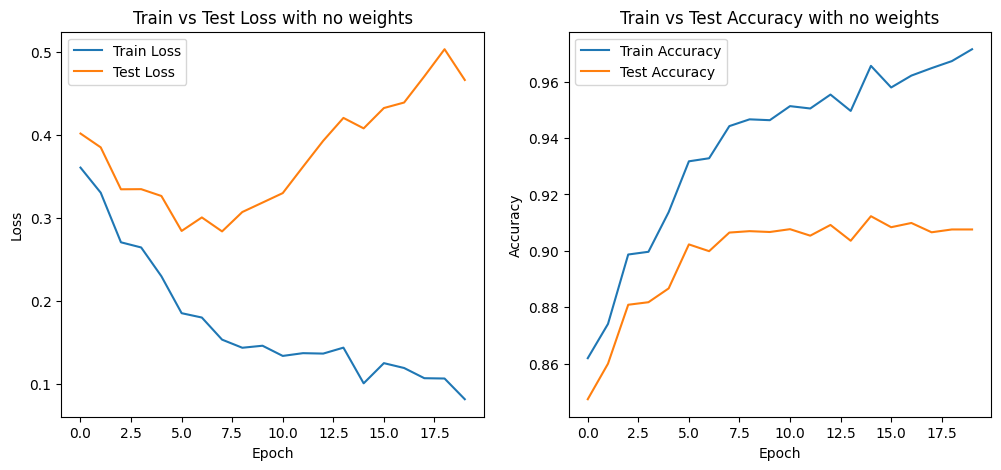

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(test_losses_resnet18, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss with no weights')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_resnet18, label='Train Accuracy')
plt.plot(test_accuracies_resnet18, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy with no weights')
plt.legend()

plt.show()

2- Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.

In [ ]:
##############################
# Your code below

# Loading ResNet18 with pretrained weights
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.fc = nn.Linear(resnet18_pretrained.fc.in_features, 10)
resnet18_pretrained = resnet18_pretrained.to(device)

# the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_pretrained.parameters(), lr=0.001)

epochs=20

train_losses_resnet18_pretrained, train_accuracies_resnet18_pretrained, test_losses_resnet18_pretrained, test_accuracies_resnet18_pretrained = train_loop(
    train_dataloader, test_dataloader, resnet18_pretrained, loss_fn, optimizer, epochs
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:

loss: 2.399091  [   64/60000]
loss: 0.408443  [ 6464/60000]
loss: 0.390456  [12864/60000]
loss: 0.331985  [19264/60000]
loss: 0.488701  [25664/60000]
loss: 0.363680  [32064/60000]
loss: 0.241237  [38464/60000]
loss: 0.422378  [44864/60000]
loss: 0.294898  [51264/60000]
loss: 0.332578  [57664/60000]
Train Error: 
 Accuracy: 88.8%, Avg loss: 0.307408 

Test Error: 
 Accuracy: 87.7%, Avg loss: 0.341863 

Epoch 2:

loss: 0.217062  [   64/60000]
loss: 0.338396  [ 6464/60000]
loss: 0.212526  [12864/60000]
loss: 0.208434  [19264/60000]
loss: 0.324035  [25664/60000]
loss: 0.386226  [32064/60000]
loss: 0.282586  [38464/60000]
loss: 0.343864  [44864/60000]
loss: 0.199331  [51264/60000]
loss: 0.204684  [57664/60000]
Train Error: 
 Accuracy: 89.4%, Avg loss: 0.286699 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.329161 

Epoch 3:

loss: 0.274689  [   64/60000]
loss: 0.193388  [ 6464/60000]
loss: 0.194088  [12864/60000]
loss: 0.207576  [19264/60000]
loss: 0.243633  [25664/60000]
loss: 0.33

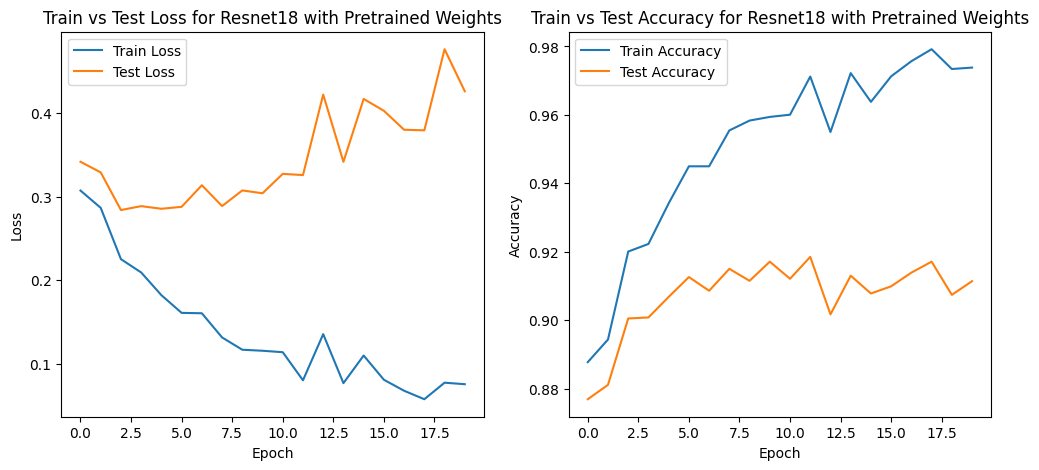

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18_pretrained, label='Train Loss')
plt.plot(test_losses_resnet18_pretrained, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss for Resnet18 with Pretrained Weights')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_resnet18_pretrained, label='Train Accuracy')
plt.plot(test_accuracies_resnet18_pretrained, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Resnet18 with Pretrained Weights')
plt.legend()

plt.show()

3- Freeze all but the last layer of your adapted ResNet model, and retrain.

In [ ]:
##############################
# Your code below

# Loading ResNet18 with pretrained weights
resnet18_adapt = models.resnet18(pretrained=True)
resnet18_adapt.fc = nn.Linear(resnet18_adapt.fc.in_features, 10)
resnet18_adapt = resnet18_adapt.to(device)

# Freezing all layers by default
for param in resnet18_adapt.parameters():
  param.requires_grad = False

# Unfreezing the last layer by setting requires_grad to True
for param in resnet18_adapt.fc.parameters():
  param.requires_grad = True

#loss function
loss_fn = nn.CrossEntropyLoss()

# Taking the parameters of the last layer which are not frozen.
non_frozen_parameters = [p for p in resnet18_adapt.parameters() if p.requires_grad]

# Optimizer with Non frozen parameters
optimizer = torch.optim.Adam(non_frozen_parameters, lr=0.001)

# Training loop
epochs = 20

train_losses_adapt, train_accuracies_adapt, test_losses_adapt, test_accuracies_adapt = train_loop(
    train_dataloader, test_dataloader, resnet18_pretrained, loss_fn, optimizer, epochs
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:

loss: 0.010320  [   64/60000]
loss: 0.015788  [ 6464/60000]
loss: 0.107097  [12864/60000]
loss: 0.090683  [19264/60000]
loss: 0.215090  [25664/60000]
loss: 0.057549  [32064/60000]
loss: 0.041451  [38464/60000]
loss: 0.062185  [44864/60000]
loss: 0.026057  [51264/60000]
loss: 0.016857  [57664/60000]
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.059264 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.409112 

Epoch 2:

loss: 0.010320  [   64/60000]
loss: 0.015788  [ 6464/60000]
loss: 0.107097  [12864/60000]
loss: 0.090683  [19264/60000]
loss: 0.215090  [25664/60000]
loss: 0.057549  [32064/60000]
loss: 0.041451  [38464/60000]
loss: 0.062185  [44864/60000]
loss: 0.026057  [51264/60000]
loss: 0.016857  [57664/60000]
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.059264 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.409112 

Epoch 3:

loss: 0.010320  [   64/60000]
loss: 0.015788  [ 6464/60000]
loss: 0.107097  [12864/60000]
loss: 0.090683  [19264/60000]
loss: 0.215090  [25664/60000]
loss: 0.05

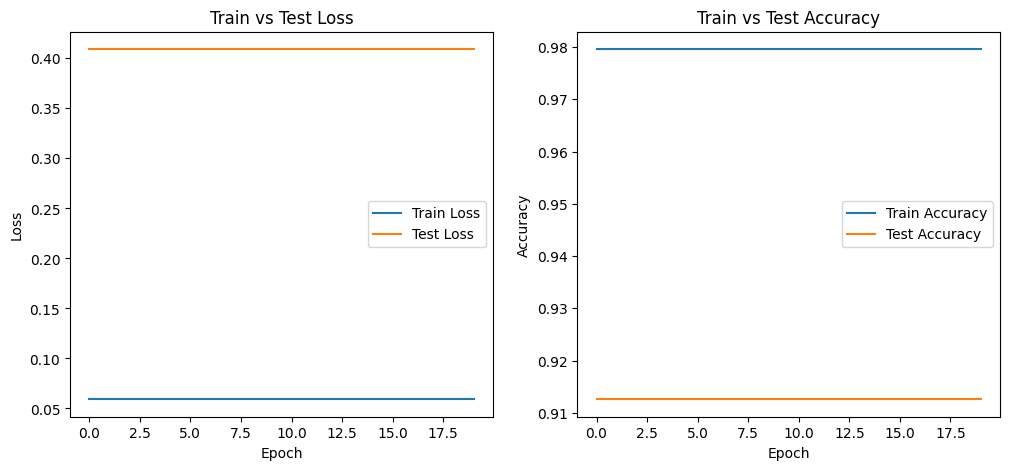

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_adapt, label='Train Loss')
plt.plot(test_losses_adapt, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_adapt, label='Train Accuracy')
plt.plot(test_accuracies_adapt, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The three strategies used to train a ResNet18 model on the FashionMNIST dataset and it shows various ways in transfer learning and model refinement, are as follows:

**Training with Random Weights:**

    This method involves initializing the model with random weights and learning from the beginning. It requires the model learning all features from scratch, which can be time-consuming and may require more data for high accuracy. The graphs for this method demonstrated a consistent increase in training accuracy, but the testing accuracy was less consistent, suggesting potential overfitting as the model became overly specialized to the training set.

**Training with Pretrained Weights:**

    Using a model that has been pretrained on a large dataset like ImageNet allows the model to utilize previously learned features. This can significantly accelerate training and enhance performance, particularly when the new dataset is similar to the original one. In this example, the training accuracy was extremely high. But the testing accuracy began to decrease after initial gains. It implys that while the model benefited from transfer learning, it may have begun to overfit the training data.

**Freezing All Layers Except the Last:**

    By freezing all layers except the last fully connected layer, the model preserves all the pre-learned features from ImageNet and only modifies the final layer to the new dataset. This approach drastically reduces the risk of overfitting, as evidenced by the very stable, albeit not perfect, testing accuracy. However, because only the last layer is trained, the model may not fully adjust to the specific nuances of the new dataset, which could limit the improvement in test accuracy.

**Differences Between the Approaches:**

**Learning from Scratch vs. Transfer Learning:**
  
    The first method is similar to learning from scratch, contrasting with the second and third methods that employ transfer learning. Transfer learning typically leads to quicker convergence and requires less data for similar or superior performance.

**Model Flexibility**:

    The first two methods allow the entire model to adapt to the new dataset, offering more flexibility but also a higher risk of overfitting. The third method limits flexibility to avoid overfitting but may not capture dataset-specific features as effectively.

**Training Speed and Overfitting:**

    The third method is usually faster because fewer parameters are updated during training, and it also reduces the risk of overfitting. However, this may come at the potential expense of not fully capturing the new dataset’s specific features, which could limit performance improvements.
